<a href="https://colab.research.google.com/github/zihoonkim/inf_car_number/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

반복(Epoch): 1, 손실 함수(Loss): 0.088680
반복(Epoch): 2, 손실 함수(Loss): 0.074384
반복(Epoch): 3, 손실 함수(Loss): 0.067115
반복(Epoch): 4, 손실 함수(Loss): 0.057344
반복(Epoch): 5, 손실 함수(Loss): 0.049951
반복(Epoch): 6, 손실 함수(Loss): 0.045600
반복(Epoch): 7, 손실 함수(Loss): 0.048019
반복(Epoch): 8, 손실 함수(Loss): 0.043755
반복(Epoch): 9, 손실 함수(Loss): 0.036678
반복(Epoch): 10, 손실 함수(Loss): 0.040554
반복(Epoch): 11, 손실 함수(Loss): 0.040528
반복(Epoch): 12, 손실 함수(Loss): 0.041559
반복(Epoch): 13, 손실 함수(Loss): 0.035239
반복(Epoch): 14, 손실 함수(Loss): 0.038817
반복(Epoch): 15, 손실 함수(Loss): 0.039156
반복(Epoch): 16, 손실 함수(Loss): 0.040352
반복(Epoch): 17, 손실 함수(Loss): 0.037662
반복(Epoch): 18, 손실 함수(Loss): 0.038842
반복(Epoch): 19, 손실 함수(Loss): 0.033551
반복(Epoch): 20, 손실 함수(Loss): 0.035957
반복(Epoch): 21, 손실 함수(Loss): 0.031779
반복(Epoch): 22, 손실 함수(Loss): 0.035640
반복(Epoch): 23, 손실 함수(Loss): 0.029777
반복(Epoch): 24, 손실 함수(Loss): 0.033330
반복(Epoch): 25, 손실 함수(Loss): 0.031784
반복(Epoch): 26, 손실 함수(Loss): 0.032404
반복(Epoch): 27, 손실 함수(Loss): 0.034318
반복(Epoch):

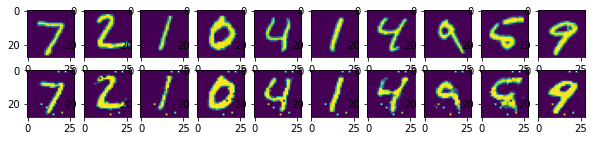

In [3]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
x_train, x_test = x_train / 255., x_test / 255.

# 설정값
learning_rate = 0.02    # 경사하강법에서 쓰이는 학습률
training_epochs = 50    # 반복횟수
batch_size = 256        # 배치개수
display_step = 1        # 손실함수 출력 주기
examples_to_show = 10   # 보여줄 MNIST Reconstruction 이미지 개수 컬럼 개수를 말한다
input_size = 784        # 28*28
hidden1_size = 256 
hidden2_size = 128      # 784 > 256 > 128 > 256 > 784 가 되는 과정


train_data = tf.data.Dataset.from_tensor_slices(x_train) ## 특징 비지도 학습이라서 x_train이 사용된다
train_data = train_data.shuffle(60000).batch(batch_size)

def random_normal_intializer_with_stddev_1():
  return tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0, seed=None)  # 학습이 진행될 때 파라미터 값을 평균 0 표준편차 1에서 w와 b를 무작위로 고른다

# Autoencoder
class AutoEncoder(tf.keras.Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    # 인코딩(Encoding) - 784 -> 256 -> 128
    self.hidden_layer_1 = tf.keras.layers.Dense(hidden1_size,
                                                activation='sigmoid',                                       #활성화 함수는 sigmoid 로
                                                kernel_initializer=random_normal_intializer_with_stddev_1(), # 위의 무작위 파라미터 w
                                                bias_initializer=random_normal_intializer_with_stddev_1())  # 위의 무작위 파라미터 b
    self.hidden_layer_2 = tf.keras.layers.Dense(hidden2_size,
                                                activation='sigmoid',
                                                kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                bias_initializer=random_normal_intializer_with_stddev_1())
    # 디코딩(Decoding) 128 -> 256 -> 784
    self.hidden_layer_3 = tf.keras.layers.Dense(hidden1_size,
                                                activation='sigmoid',
                                                kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                bias_initializer=random_normal_intializer_with_stddev_1())
    self.output_layer = tf.keras.layers.Dense(input_size,
                                                activation='sigmoid',
                                                kernel_initializer=random_normal_intializer_with_stddev_1(),
                                                bias_initializer=random_normal_intializer_with_stddev_1())

  def call(self, x): # 위의 과정을 불러온다
    H1_output = self.hidden_layer_1(x)             #  x=784, H1_output = 256, 
    H2_output = self.hidden_layer_2(H1_output)     # H2_output = 128
    H3_output = self.hidden_layer_3(H2_output)     # H3_output = 256
    reconstructed_x = self.output_layer(H3_output) # reconstructed_x = 784

    return reconstructed_x

# MSE 손실 함수를 정의합니다.
@tf.function
def mse_loss(y_pred, y_true):
  return tf.reduce_mean(tf.pow(y_true - y_pred, 2)) # MSE(Mean of Squared Error) 손실함수 여기서 특이점은 y_true, 실제 값이 input값이라는것 즉 정답 = input 데이터 

# 최적화를 위한 RMSProp 옵티마이저를 정의
optimizer = tf.optimizers.RMSprop(learning_rate)

# 최적화를 위한 function을 정의
@tf.function
def train_step(model, x):
  # 타겟데이터 = 인풋데이터
  y_true = x
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss = mse_loss(y_pred, y_true)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Autoencoder 모델을 선언.
AutoEncoder_model = AutoEncoder()

# 지정된 횟수만큼 최적화를 수행
for epoch in range(training_epochs):
  # 모든 배치들에 대해서 최적화
  # Autoencoder는 타겟 레이블(label) y가 필요없다.
  for batch_x in train_data:
    # 옵티마이저를 실행해서 파라마터들을 업데이트
    _, current_loss = train_step(AutoEncoder_model, batch_x), mse_loss(AutoEncoder_model(batch_x), batch_x) # batch_x가 곧 y_true 값이니까!
  # 지정된 epoch마다 학습결과를 출력
  if epoch % display_step == 0:
    print("반복(Epoch): %d, 손실 함수(Loss): %f" % ((epoch+1), current_loss))

# 테스트 데이터로 Reconstruction을 수행
reconstructed_result = AutoEncoder_model(x_test[:examples_to_show])
# 원본 MNIST 데이터와 Reconstruction 결과를 비교
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
  a[0][i].imshow(np.reshape(x_test[i], (28, 28)))
  a[1][i].imshow(np.reshape(reconstructed_result[i], (28, 28)))
f.savefig('reconstructed_mnist_image.png')  # reconstruction 결과를 png로 저장
f.show()
plt.draw()
